## **We attempt to use BERT for multi-class classification of toxic texts.**

In [40]:
import pandas as pd
import numpy as np

import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split


import transformers
from transformers import AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm
import seaborn as sns
import matplotlib as plt
import torch.nn.functional as Func

These are all the imports, initially we made use of the scheduler but later deicded against the added complexity of code and insignificant performance gains. Other imports are primarily used for functions tasks.

In [32]:


# Load your dataset
file_path = '/content/train.csv'  # Replace with the path to your dataset file
data = pd.read_csv(file_path)

# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize and count tokens for each text
token_counts = []
for text in data['comment_text']:
    # Encode the text, adding special tokens for BERT (CLS and SEP)
    encoded_text = tokenizer.encode(text, add_special_tokens=True)
    token_counts.append(len(encoded_text))




Token indices sequence length is longer than the specified maximum sequence length for this model (631 > 512). Running this sequence through the model will result in indexing errors


In [33]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
token_counts = [len(tokenizer.encode(text, add_special_tokens=True)) for text in data['comment_text']]

Token indices sequence length is longer than the specified maximum sequence length for this model (631 > 512). Running this sequence through the model will result in indexing errors


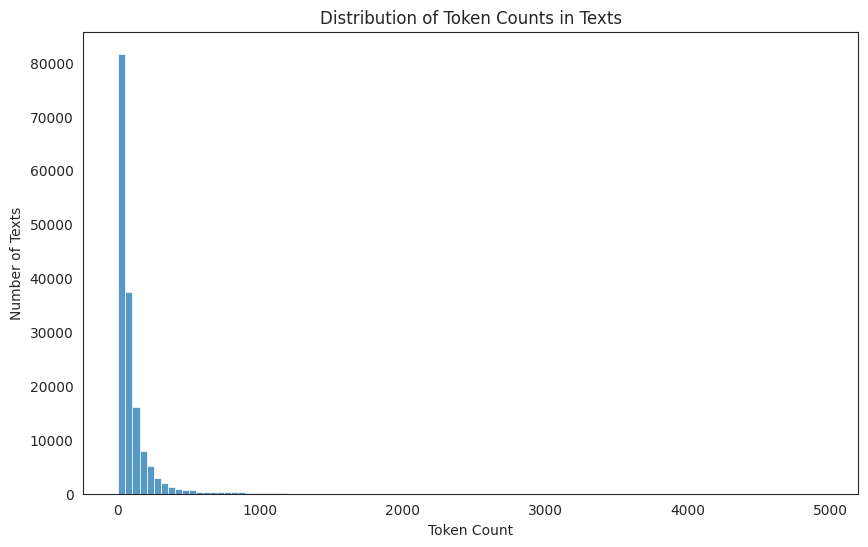

In [42]:
# Create a histogram of token counts
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.histplot(token_counts, bins=100, kde=False)
plt.title('Distribution of Token Counts in Texts')
plt.xlabel('Token Count')
plt.ylabel('Number of Texts')
sns.set_style("white")  # Set style to white for better appearance in LaTeX
plt.show()

In [37]:
percentiles = [np.percentile(token_counts, p) for p in range(0, 101, 10)]
print(percentiles)

[4.0, 15.0, 22.0, 31.0, 40.0, 52.0, 67.0, 89.0, 125.0, 207.0, 4950.0]


In [38]:
percentile_95 = np.percentile(token_counts, 95)
print(percentile_95)

310.5


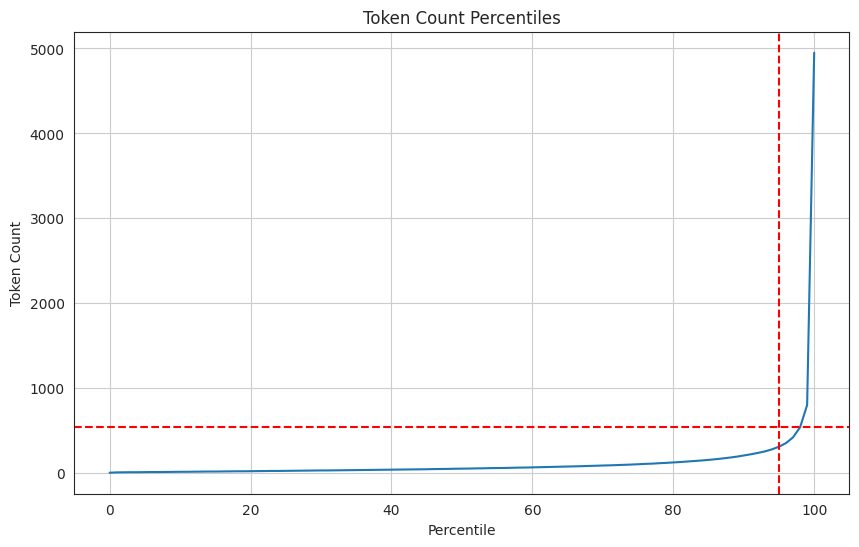

In [43]:
percentiles = [np.percentile(token_counts, p) for p in range(101)]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(101), percentiles)
plt.axhline(y=percentile_98, color='r', linestyle='--')
plt.axvline(x=95, color='r', linestyle='--')
plt.title('Token Count Percentiles')
plt.xlabel('Percentile')
plt.ylabel('Token Count')
plt.grid(True)
plt.show()

# **In this model we will use BERT to solve this classification problem**

In [44]:
data = pd.read_csv("/content/train.csv")

In [45]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [46]:
# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenization function
def tokenize_data(text, max_length=512):
    return tokenizer.encode_plus(
        text,
        max_length=max_length,
        truncation=True,
        padding='max_length',
        return_tensors='pt'
    )

# Preprocess the data
class CommentDataset(Dataset):
    def __init__(self, comments, labels):
        self.comments = [tokenize_data(comment) for comment in comments]
        self.labels = labels

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, idx):
        item = {key: val.squeeze() for key, val in self.comments[idx].items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

# Prepare dataset
labels = data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values
comments = data['comment_text'].tolist()

# Split the dataset
train_comments, val_comments, train_labels, val_labels = train_test_split(comments, labels, test_size=0.2, random_state=42)

# Create datasets
train_dataset = CommentDataset(train_comments, train_labels)
val_dataset = CommentDataset(val_comments, val_labels)

In [47]:
from transformers import BertForSequenceClassification
from torch.optim import AdamW
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'

# Load the pre-trained BERT model
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=6
)
model.to(device)

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [48]:
from torch.nn import BCEWithLogitsLoss

In [52]:

def train(model, train_loader, optimizer, epochs=1):
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        for i, batch in enumerate(train_loader):
            optimizer.zero_grad()

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            # Compute loss: Ensure labels are of the correct shape
            logits = outputs.logits
            loss_fn = BCEWithLogitsLoss()
            loss = loss_fn(logits, labels.float())

            loss.backward()
            optimizer.step()
            batch_loss = loss.item()
            total_loss += loss.item()

# Print loss for each batch
            print(f'Epoch {epoch+1}, Batch {i+1}/{len(train_loader)}, Batch Loss: {batch_loss}')

        # Print total loss for the epoch
        print(f'Epoch {epoch+1}, Total Loss: {total_loss / len(train_loader)}')
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
train(model, train_loader, optimizer)

Epoch 1, Batch 15936/15957, Batch Loss: 0.03932883217930794
Epoch 1, Batch 15937/15957, Batch Loss: 0.006917535327374935
Epoch 1, Batch 15938/15957, Batch Loss: 0.0863385945558548
Epoch 1, Batch 15939/15957, Batch Loss: 0.0003109783574473113
Epoch 1, Batch 15940/15957, Batch Loss: 0.001189853181131184
Epoch 1, Batch 15941/15957, Batch Loss: 0.07620935142040253
Epoch 1, Batch 15942/15957, Batch Loss: 0.0003191116265952587
Epoch 1, Batch 15943/15957, Batch Loss: 0.05924845486879349
Epoch 1, Batch 15944/15957, Batch Loss: 0.012598611414432526
Epoch 1, Batch 15945/15957, Batch Loss: 0.0009174399892799556
Epoch 1, Batch 15946/15957, Batch Loss: 0.03199072554707527
Epoch 1, Batch 15947/15957, Batch Loss: 0.04256858676671982
Epoch 1, Batch 15948/15957, Batch Loss: 0.0005401548696681857
Epoch 1, Batch 15949/15957, Batch Loss: 0.04476992040872574
Epoch 1, Batch 15950/15957, Batch Loss: 0.07974638044834137
Epoch 1, Batch 15951/15957, Batch Loss: 0.019866935908794403
Epoch 1, Batch 15952/15957, B

In [53]:
def evaluate(model, val_loader):
    model.eval()

    total_loss = 0
    loss_fn = BCEWithLogitsLoss()

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = loss_fn(logits, labels.float())
            total_loss += loss.item()

    print(f'Validation Loss: {total_loss / len(val_loader)}')

# Evaluate the model
val_loader = DataLoader(val_dataset, batch_size=8)

evaluate(model, val_loader)


Validation Loss: 0.0392671263384292


In [54]:
X_test = pd.read_csv("/content/test.csv")
y_test = pd.read_csv("/content/test_labels.csv")

In [55]:
X_test = X_test['comment_text']
y_test = y_test[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

In [56]:
indices_to_remove = y_test[y_test['toxic'] == -1].index

y_test_filtered = y_test.drop(indices_to_remove)
X_test_filtered = X_test.drop(indices_to_remove)

In [57]:
test_comments = X_test_filtered.tolist()

# Create a dataset for test data
class TestDataset(Dataset):
    def __init__(self, comments):
        self.comments = [tokenize_data(comment) for comment in comments]

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, idx):
        item = {key: val.squeeze().to(device) for key, val in self.comments[idx].items()}
        return item

test_dataset = TestDataset(test_comments)

# Create DataLoader for test data
test_loader = DataLoader(test_dataset, batch_size=8)


In [58]:
from sklearn.metrics import accuracy_score

def evaluate_model_accuracy(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.sigmoid(logits).cpu().numpy() > 0.5  # Converting to binary output
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = accuracy_score(np.array(all_labels), np.array(all_preds))
    return accuracy

# Assuming y_test_filtered is available and properly formatted
y_test_filtered_labels = y_test_filtered.values
test_dataset_with_labels = CommentDataset(test_comments, y_test_filtered_labels)
test_loader_with_labels = DataLoader(test_dataset_with_labels, batch_size=5)

# Get accuracy
accuracy = evaluate_model_accuracy(model, test_loader_with_labels)
print(f"Accuracy: {accuracy}")


Accuracy: 0.8567632623714402


# **Custom sentence**
We add functionality where we can test our own sentences and the model can give us accurate results in terms of what the content of the message is.

In [132]:
sen = "Kanye west is the greatest of all time"



In [133]:
def preprocess_for_bert(sentence, tokenizer, max_length=512):
    """Preprocess a single sentence for BERT."""
    inputs = tokenizer.encode_plus(
        sentence,
        add_special_tokens=True,
        max_length=max_length,
        truncation=True,
        padding='max_length',
        return_tensors='pt'
    )
    return inputs

# Example sentence

# Tokenize the sentence
inputs = preprocess_for_bert(sen, tokenizer)


In [134]:
# Move inputs to device
input_ids = inputs['input_ids'].to(device)
attention_mask = inputs['attention_mask'].to(device)


In [135]:
model.eval()

# Predict
with torch.no_grad():
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    probabilities = torch.sigmoid(logits).squeeze()

# Convert probabilities to numpy array
probabilities = probabilities.cpu().numpy()

This returns the predicted labels in a list, so just numbers

In [136]:
threshold = 0.5
predicted_labels = (probabilities > threshold).astype(int)

# Print predicted labels
print("Predicted labels:", predicted_labels)


Predicted labels: [0 0 0 0 0 0]


In [111]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

predicted_probabilities = list(zip(labels, probabilities))


for label, prob in predicted_probabilities:
    print(f"{label}: {prob:.4f}")
threshold = 0.5
predicted_labels = (probabilities > threshold).astype(int)
# we want the numpy array to match with the names of the class, thus we use a dictionary
predicted_labels_dict = dict(zip(labels, predicted_labels))


for label, label_class in predicted_labels_dict.items():
    print(f"{label}: {'Yes' if label_class == 1 else 'No'}")


toxic: 0.9979
severe_toxic: 0.6118
obscene: 0.9911
threat: 0.0195
insult: 0.9603
identity_hate: 0.0773
toxic: Yes
severe_toxic: Yes
obscene: Yes
threat: No
insult: Yes
identity_hate: No


# **In this section we look at how we can get some better more detailed statistics



**

In [ ]:
def predict(sentence, model, tokenizer, device):
    """Generate predictions for a single sentence."""
    inputs = preprocess_for_bert(sentence, tokenizer)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probabilities = torch.sigmoid(logits).squeeze()
        return probabilities.cpu().numpy()

# Example test data
test_sentences = ["Test sentence 1", "Test sentence 2", ...]  # Replace with your sentences
true_labels = [...]  # Replace with the true labels for the test data

predicted_probs = [predict(sentence, model, tokenizer, device) for sentence in test_sentences]
predicted_labels = [(prob > 0.5).astype(int) for prob in predicted_probs]


In [65]:
from torch.utils.data import DataLoader

# Create a DataLoader for the test dataset
test_loader = DataLoader(test_dataset_with_labels, batch_size=32, shuffle=False)

# List to store predictions
all_predictions = []

# Predict
model.eval()  # Put the model in evaluation mode
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.sigmoid(logits)
        all_predictions.append(predictions)

# Concatenate all predictions
predictions = torch.cat(all_predictions, dim=0)


In [76]:
threshold = 0.5
predicted_labels = (predictions > threshold).cpu().numpy()



In [81]:
from sklearn.metrics import classification_report


true_labels = np.array([item['labels'].cpu().numpy() for item in test_dataset_with_labels])


predicted_labels = (predictions > threshold).cpu().numpy()


report = classification_report(true_labels, predicted_labels, target_names=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])

print(report)



               precision    recall  f1-score   support

        toxic       0.50      0.92      0.65      6090
 severe_toxic       0.32      0.59      0.41       367
      obscene       0.55      0.82      0.66      3691
       threat       0.60      0.49      0.54       211
       insult       0.64      0.74      0.69      3427
identity_hate       0.79      0.41      0.54       712

    micro avg       0.54      0.81      0.65     14498
    macro avg       0.57      0.66      0.58     14498
 weighted avg       0.56      0.81      0.65     14498
  samples avg       0.08      0.08      0.08     14498



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
